In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import datetime
from datetime import datetime, timedelta
from datetime import date
import os

### Functions

In [2]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [3]:
def create_df(i):
    print(i)
    print(dictCountries[i])
    name_country = str(dictCountries[i])
    df = data.loc[data.Country == name_country]
    df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
    df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
    df['OTG_cases'] = df['MA'] + df['MSTD_cases']
    df['UTG_cases'] = df['MA'] - df['MSTD_cases']

    df['MA_d'] = df['New_deaths'].rolling(window=7, min_periods=1).mean()
    df['MSTD_deaths'] = df['New_deaths'].rolling(window=7, min_periods=1).std()
    df['OTG_deaths'] = df['MA_d'] + df['MSTD_deaths']
    df['UTG_deaths'] = df['MA_d'] - df['MSTD_deaths']
    df.to_csv(f'{Laufwerk}{pfad_output}//Dataframes//df_{dictCountries[i]}.csv')

    
    # shift 2020 to 2021 (24.10.2021 PW)
    df["cases2020"] = df['MA']
    df["cases2020"] = df["cases2020"].shift(365)
    
    df["deaths2020"] = df['MA_d']
    df["deaths2020"] = df["deaths2020"].shift(365)
    
    case_fatality = str(round( 100 * (df["MA_d"].iloc[-1] / df["MA"].iloc[-20]),1 ))
    
    chart_cases(df, name_country, case_fatality)
    
    return df, name_country

In [4]:
def chart_cases(df, name_country, case_fatality):
    def y_axis_thousands(x, pos):
        # 'The two args are the value and tick position'
        return '{:0,d}'.format(int(x)).replace(",", ".")

    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(h, v))
    formatter = FuncFormatter(y_axis_thousands)
    ax.yaxis.set_major_formatter(formatter)

    plt.plot(df.Date_reported, df['New_cases'], color="blue", alpha=0.7, marker=".", markersize=size * 0.5,
             linestyle="", label="cases")
    plt.plot(df.Date_reported, df['MA'], color="blue", marker="", linestyle="solid", label="cases (7-Tage Mittel)",
             linewidth=size * 0.2)

    
       # shift 2020 to 2021 (24.10.2021 PW)
#     plt.plot(df.Date_reported, df['cases2020'], color="blue", marker="", linestyle="dotted", label="cases 2020 (7-Tage Mittel)",
#              linewidth=size * 0.2)    
    
    
    ax.set_xlabel("time", fontsize=size)
    ax.set_ylabel("cases", color="blue", fontsize=size)

    ax.tick_params(labelsize=size * 0.5)

    plt.legend(loc='upper right',
               bbox_to_anchor=(0.5, -0.15),
               fancybox=True,
               shadow=True,
               ncol=1,
               fontsize=size)

    # twin object for two different y-axis on the sample plot
    ax2 = ax.twinx()
    ax2.grid(None)

    locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)

    ax.set_ylim(ymin=0)

    ax2.plot(df.Date_reported, df['MA_d'], color="red", marker="", linestyle="solid", label="deaths (7-Tage Mittel)",
             linewidth=size * 0.2)
    ax2.set_ylabel("deaths", color="red", fontsize=size)
    

       # shift 2020 to 2021 (24.10.2021 PW)
#     ax2.plot(df.Date_reported, df['deaths2020'], color="red", marker="", linestyle="dotted", label="deaths 2020 (7-Tage Mittel)",
#              linewidth=size * 0.2)    
    
    ax2.tick_params(labelsize=size * 0.5)

    plt.title(f'{name_country} CFR(20) = {case_fatality}  (WHO-Daten) \n', fontsize=size)
    plt.legend(loc='upper left',
               bbox_to_anchor=(0.5, -0.15),
               fancybox=True,
               shadow=True,
               ncol=1,
               fontsize=size)
    plt.suptitle(f'{today} PW',
                 fontsize=size * 0.7, y=0.92)
    plt.savefig(Laufwerk + pfad_output + " cases " + name_country + " recent.png", dpi=dpi, bbox_inches='tight')


In [5]:
now = datetime.now()

Laufwerk = "D:\\"
name_output_df = 'Dataframes\\data_WHO_data.csv'

pfad_output = "Github\\Auswertung_Covid_19\\output\\"
# pfad_onedrive = "OneDrive\\Auswertung_Covid_19\\"
pfad_input = "Github\\Auswertung_Covid_19\\input\\"

Programm_Name = "WHO"

# Datum einstellen
minticks = 14
maxticks = 14

today = date.today().strftime("%d.%m.%Y")


a = str(date.today().strftime("%Y-%m-%d"))
# tage = days_between(a, "2020-03-01")
# tage = days_between(a, "2020-04-01")
tage = days_between(a, "2020-04-01")

ts_x = str(datetime.today() - timedelta(tage))
ts = pd.to_datetime(ts_x, utc=True)

# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 30

# output größe der bilder
h = 16
v = 9
dpi = 150
# pE = 100_000


#


# Webabruf - CSV einlesen
data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")
data = data.drop(columns=['Country_code', 'WHO_region', 'Cumulative_deaths'])
data['Date_reported'] = pd.to_datetime(data.Date_reported, utc=True)
data = data.loc[data.Date_reported >= ts, :]
data = data[data.New_cases != 0]

dictCountries = {
    "0": "Germany",
    "1": "France",
    "2": "Austria",
#     "3": "Poland",
#     "4": "Czechia",
#     "5": "Switzerland",
#     "6": "India",
    "7": "Italy",
    "8": "Spain",
    "9": "The United Kingdom",
    "10": "Israel",
    "11": "Sweden",
#     "12": "United States of America",
#     "15": "Russian Federation",
#     "16": "Estonia",
#     "17": "Netherlands",
#     "18:": "Greece",
#     "19": "Denmark",
    "20": "South Africa",
    "21": "Botswana"
}

#
# # # get list of all countries
# listCountries = data["Country"].unique()
# # create dict out of list
# dictCountries = {i: listCountries[i] for i in range(0, len(listCountries))}
# # # print(dictCountries)


# Dataframes erzeugen



0
Germany


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

1
France


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

2
Austria


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

7
Italy


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

8
Spain


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

9
The United Kingdom


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

10
Israel


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

11
Sweden


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

20
South Africa


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

21
Botswana


<ipython-input-3-09a96a7372d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['New_cases'].rolling(window=7, min_periods=1).mean()
<ipython-input-3-09a96a7372d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSTD_cases'] = df['New_cases'].rolling(window=7, min_periods=1).std()
<ipython-input-3-09a96a7372d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

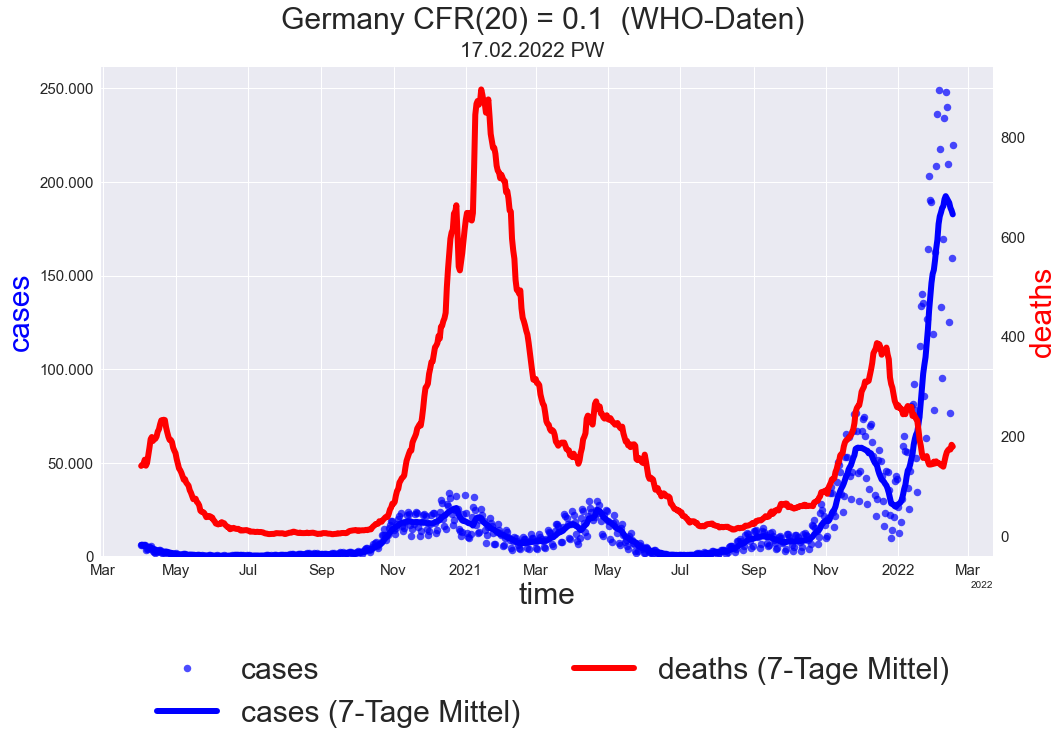

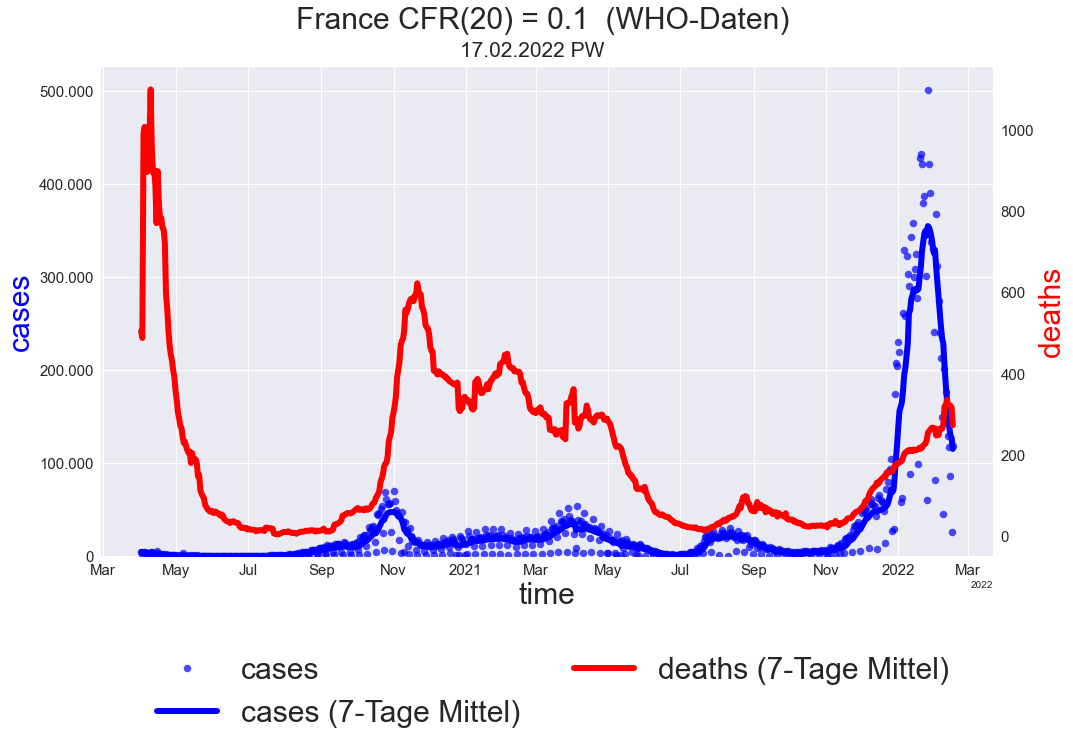

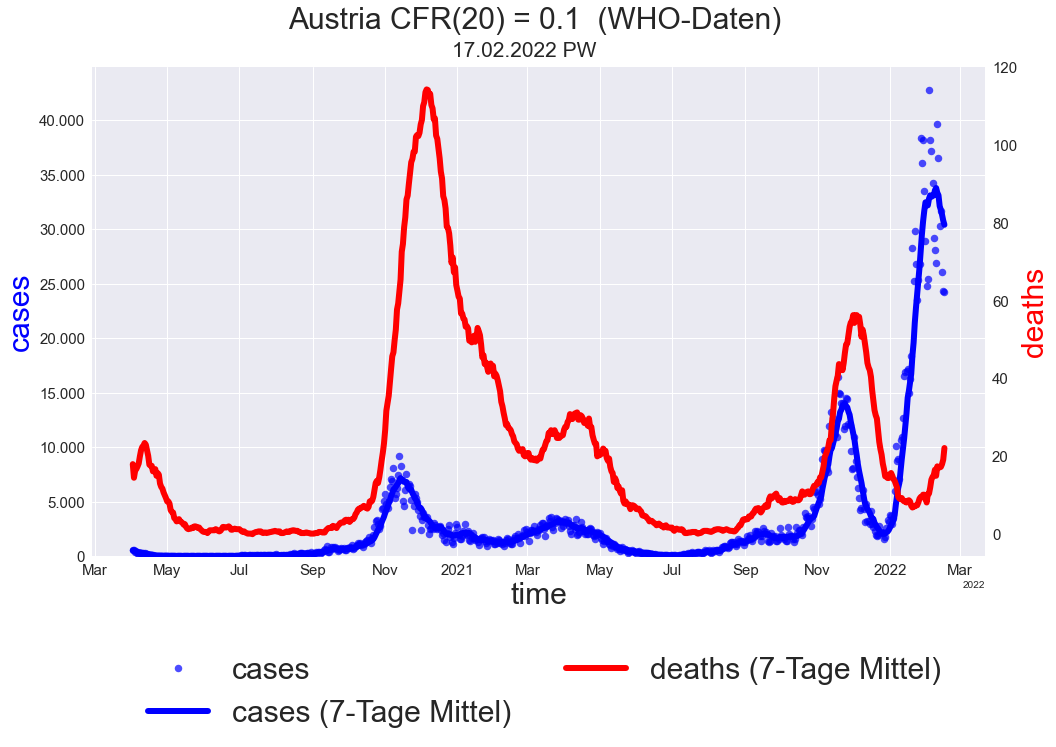

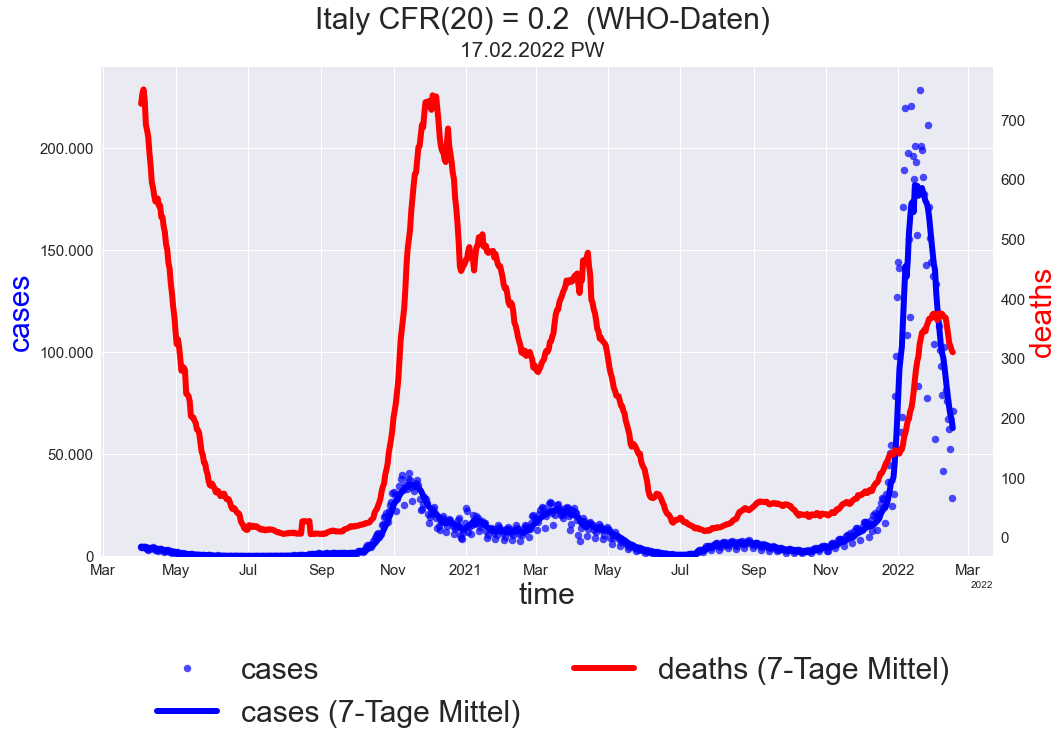

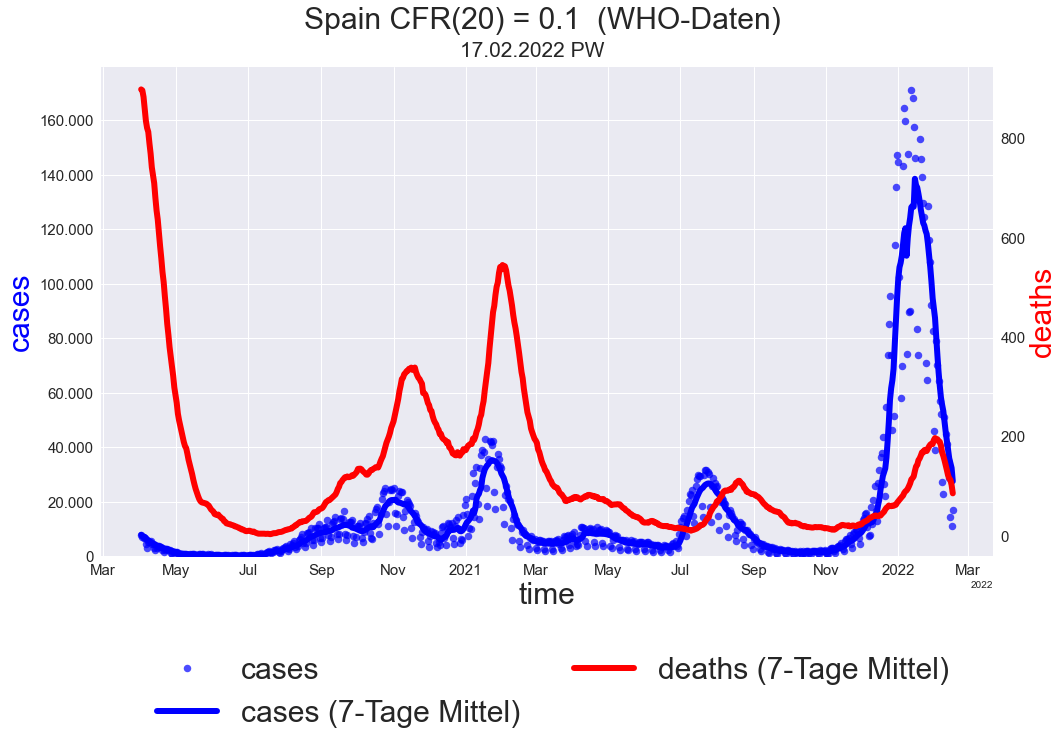

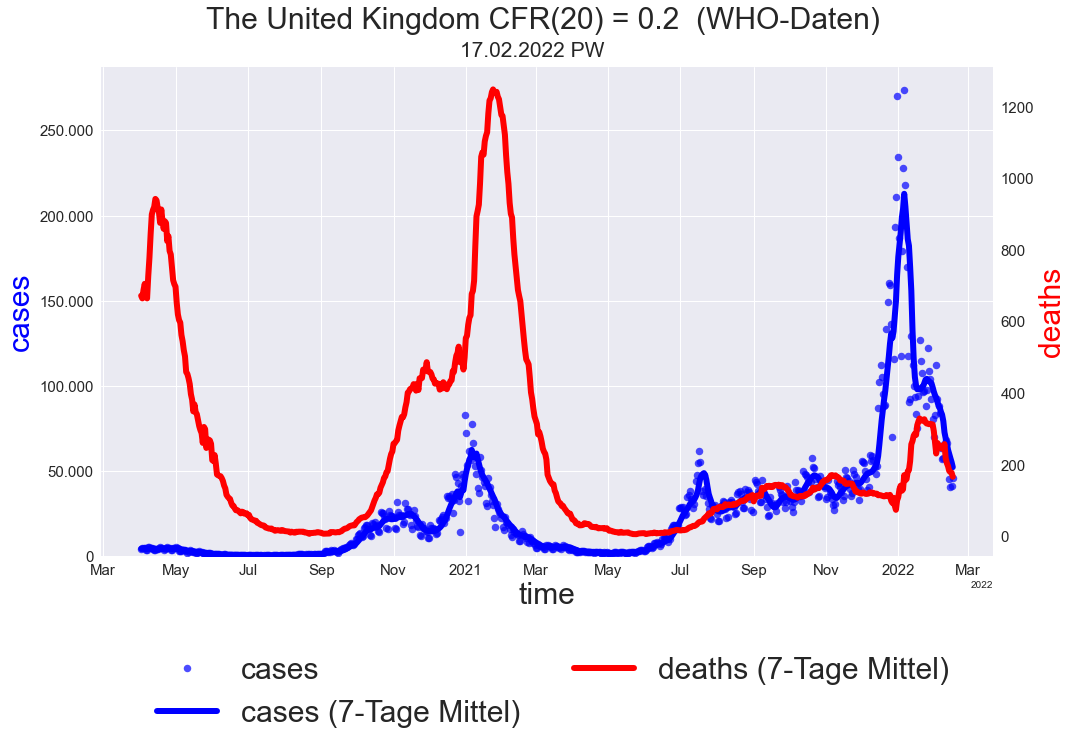

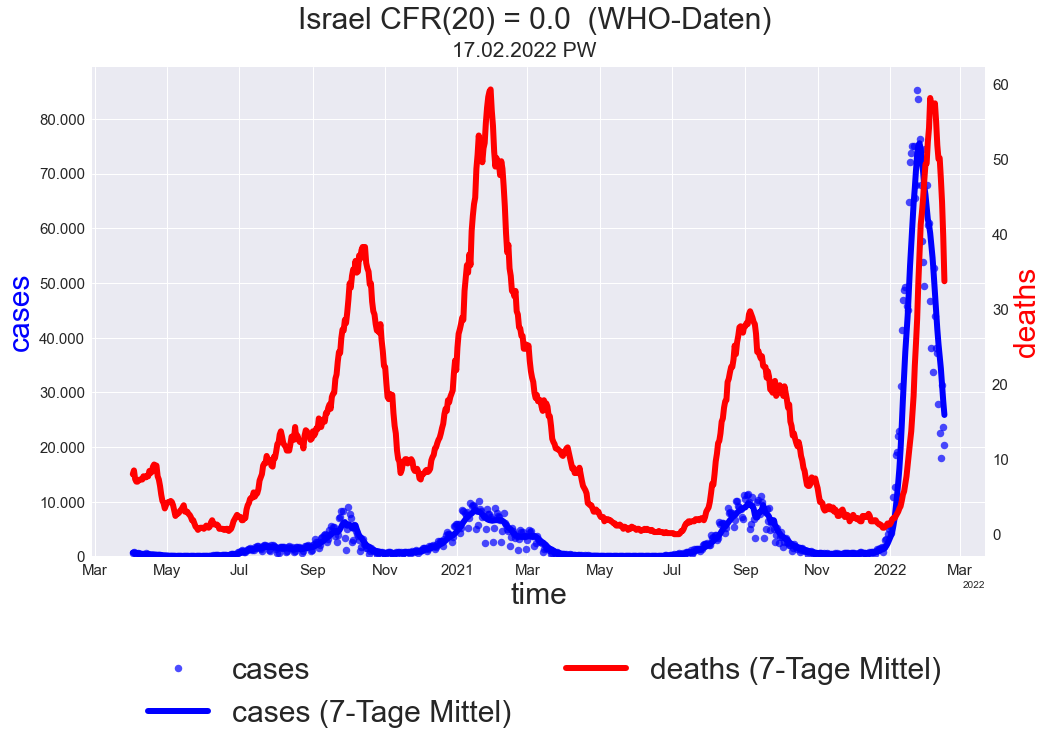

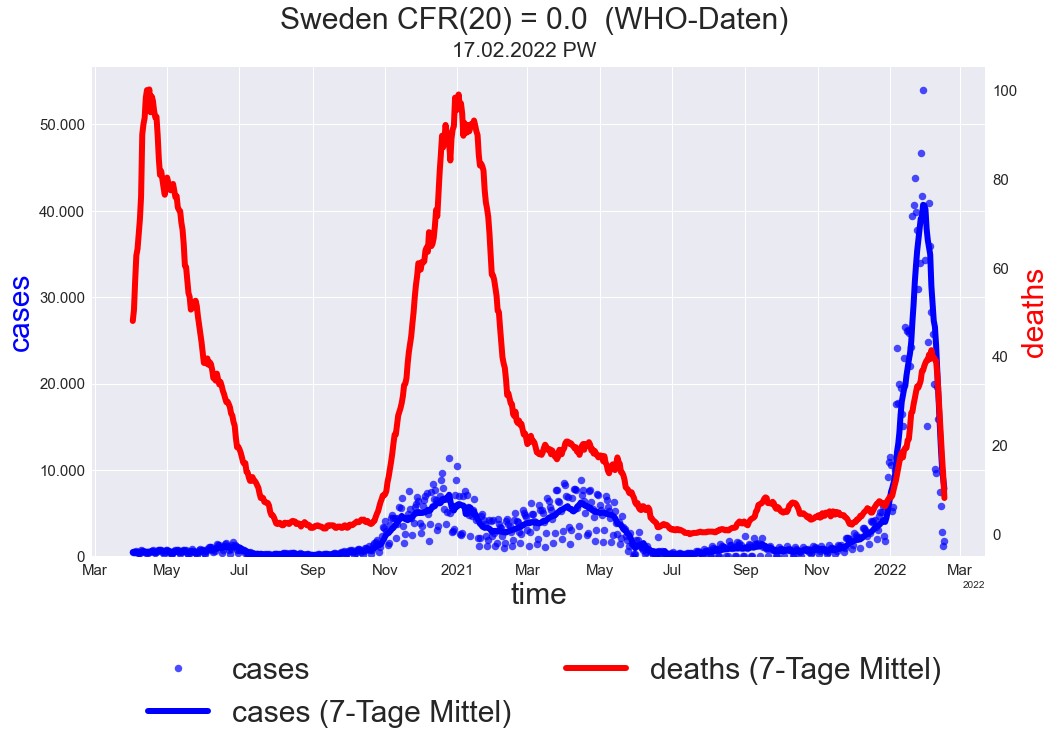

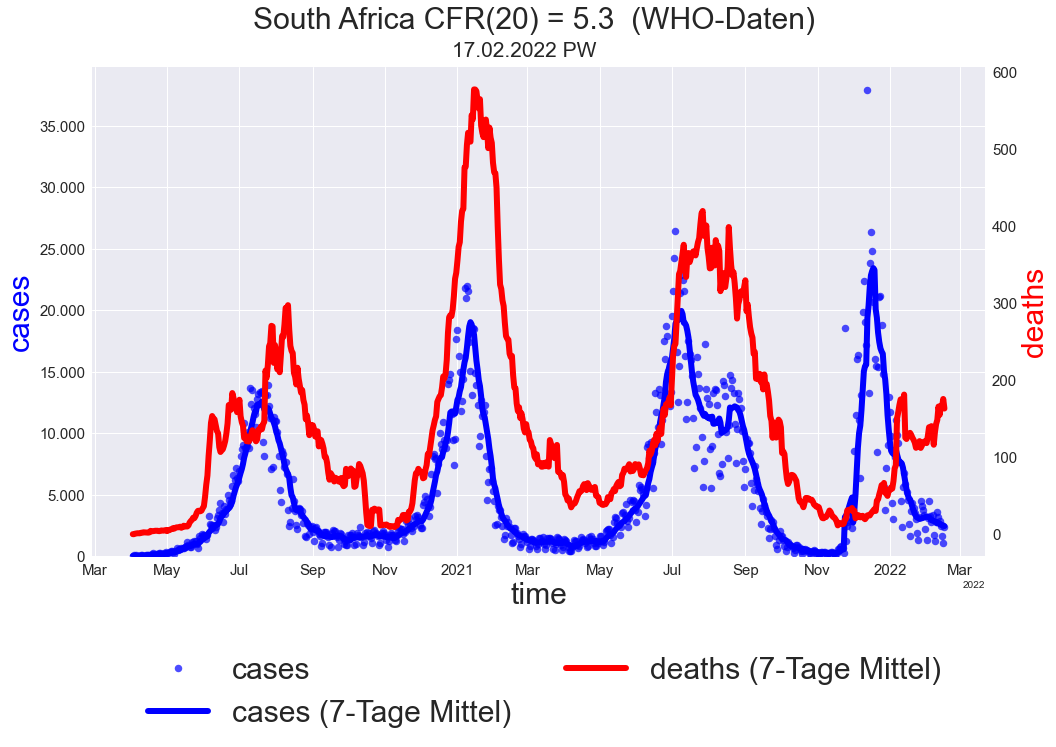

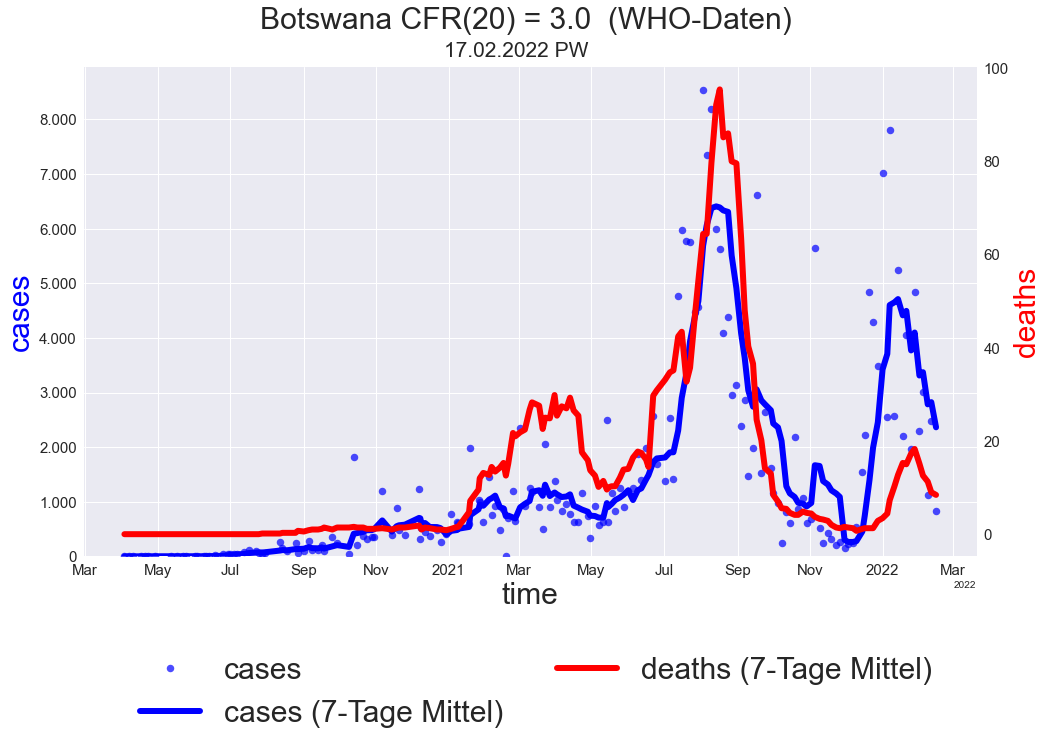

In [6]:
for i in dictCountries:
    create_df(i)
    

pc = os.environ['COMPUTERNAME']
now2 = datetime.now()
# Laufzeit
x = now2 - now
x = round(x.total_seconds(), 2)
#print(f'performance {pc} = {x} seconds')

In [7]:

df = data.loc[data.Country == "Germany"]
# df

In [8]:
d = {'col1': [1, 2, 3, 4, 5], 'col2': [1.1, 2.2, 3.3, 4.4, 5.5]}
df = pd.DataFrame(data=d)
df["col2"].shift(periods=2)

0    NaN
1    NaN
2    1.1
3    2.2
4    3.3
Name: col2, dtype: float64